# Imports

In [72]:
# User-defined functions!
# All data preparation functions for GDP data and explanatory variables
from Functions.data_prep import data_GDP, data_explanatory
# imports for Moran's I analysis and plotting graphs
from Functions.spatial_functions import spatial_weight_matrix, neighborhood_dict_creation, global_moran_val, local_moran_val,lisa_df_update, local_moran_density_plot, local_moran_plots, lisa_cluster_map
# Spatial outlier analysis
from Functions.Spatial_outlier_analysis import explanatory_HL_LH_df_creation, create_interactive_bar_graph, create_categorical_heatmap_HL, country_code_analysis, create_heatmap

# All required imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import folium

random.seed(120)

# Spatial Autocorrelation Analysis

## Data preparation

In [73]:
# Data preparation and cleaning for GDP data
# Setting time_period option to average over all years since this is spatial analysis and time is aggregated
time_period_option = 'average_all_years'
gdf_lvl = data_GDP(2, time_period_option)

### Data Exploration: Avg GDPs across NUTS regions

In [74]:
# Center coordinates for the map
eu_center = [50.8503, 4.3517]

# Create a folium map centered on the EU center
m = folium.Map(location=eu_center, zoom_start=4)

# Add choropleth layer with GDP values
folium.Choropleth(
    geo_data=gdf_lvl,
    data=gdf_lvl,
    columns=['NUTS_ID', 'GDP_VALUE'],
    key_on='feature.properties.NUTS_ID',
    fill_color='OrRd',  # Color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='GDP Value',
    highlight=True,
    name='GDP Choropleth',
).add_to(m)

# Add GeoJSON layer with tooltip
folium.GeoJson(
    gdf_lvl,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['NUTS_ID', 'GDP_VALUE'], labels=True, sticky=False)
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

## Spatial Weights Creation

In [75]:
# Setting index to NUTS_ID before you create the spatial weights (so neighborhood dictionary has NUTS ID values)
gdf_lvl.set_index('NUTS_ID', inplace=True)
w_adaptive = spatial_weight_matrix(gdf_lvl, 15)
neighbor_weights_dict = neighborhood_dict_creation(w_adaptive)

### Global and Local Moran's I

In [76]:
global_moran = global_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)
lisa = local_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)

In [77]:
print("Global Moran's I value: "+str(global_moran.I))
print("p-value: "+str(global_moran.p_sim))

Global Moran's I value: 0.63686212878378
p-value: 0.001


#### Neighbour number v.s. Global Moran's I

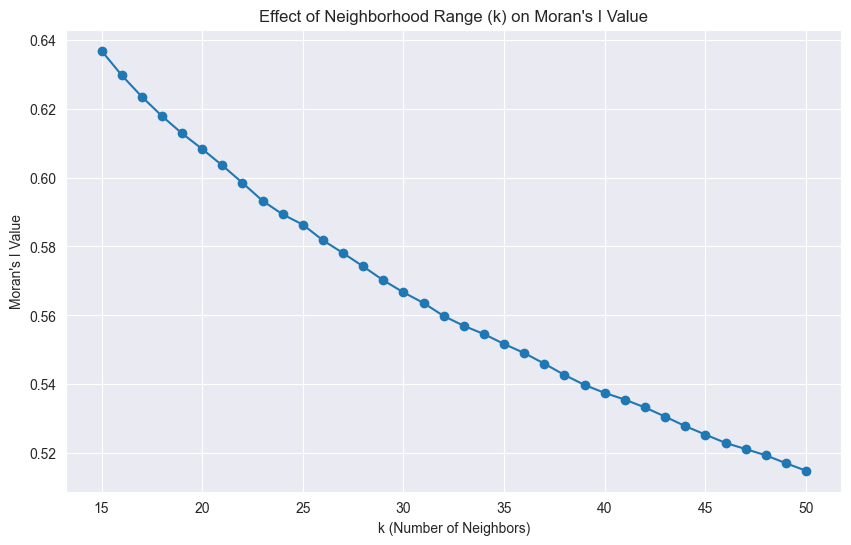

In [78]:
# Define the range of k values you want to test
k_values = range(15, 51)  # testing k from 1 to 50
# Initialize an empty list to store Moran's I value
moran_values = []

# Loop through each k value
for k in k_values:
    # Create the spatial weight matrix for the current k value
    w_adaptive = spatial_weight_matrix(gdf_lvl, k)
    # Calculate Moran's I value
    moran = global_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)
    # Append the Moran's I value to the list
    moran_values.append(moran.I)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, moran_values, marker='o')
plt.title("Effect of Neighborhood Range (k) on Moran's I Value")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Moran's I Value")
plt.grid(True)
plt.show()

In [79]:
# Remember to reset index before updating it with lisa values and corresponding significance and quadrant values
gdf_lvl.reset_index(inplace=True)

In [80]:
# Updating the dataframe to include local lisa information
gdf_lvl = lisa_df_update(gdf_lvl, lisa)

In [81]:
# Saving the final df updated with LISA values
gdf_lvl.to_csv("results/SAC_local_NUTS2.csv")

### Local Moran's I plots

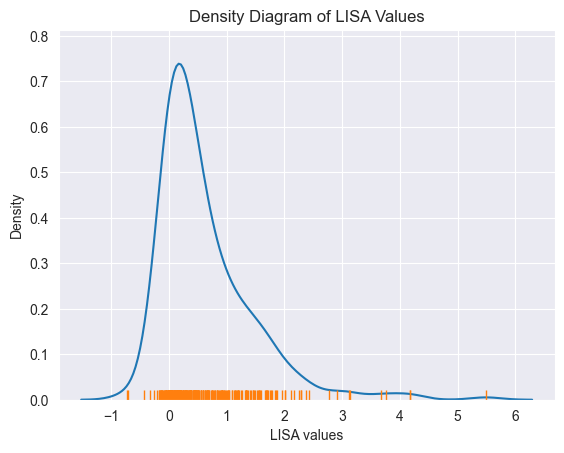

In [82]:
local_moran_density_plot(lisa)

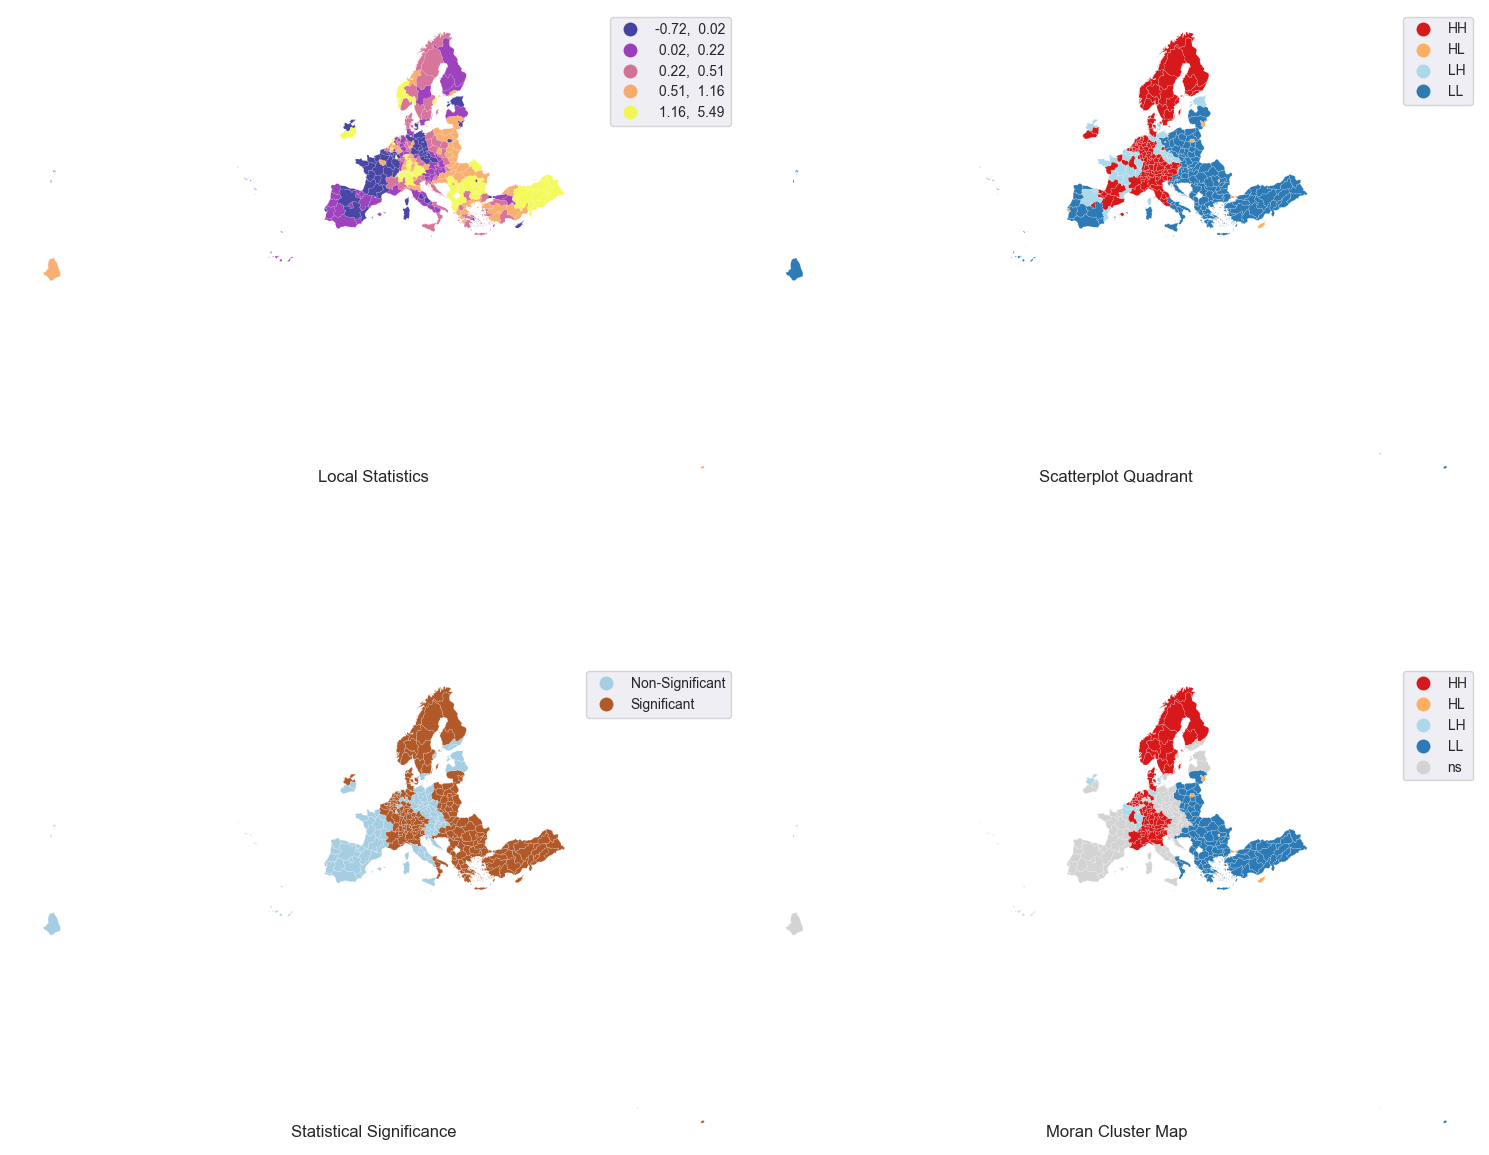

In [83]:
local_moran_plots(gdf_lvl, lisa)

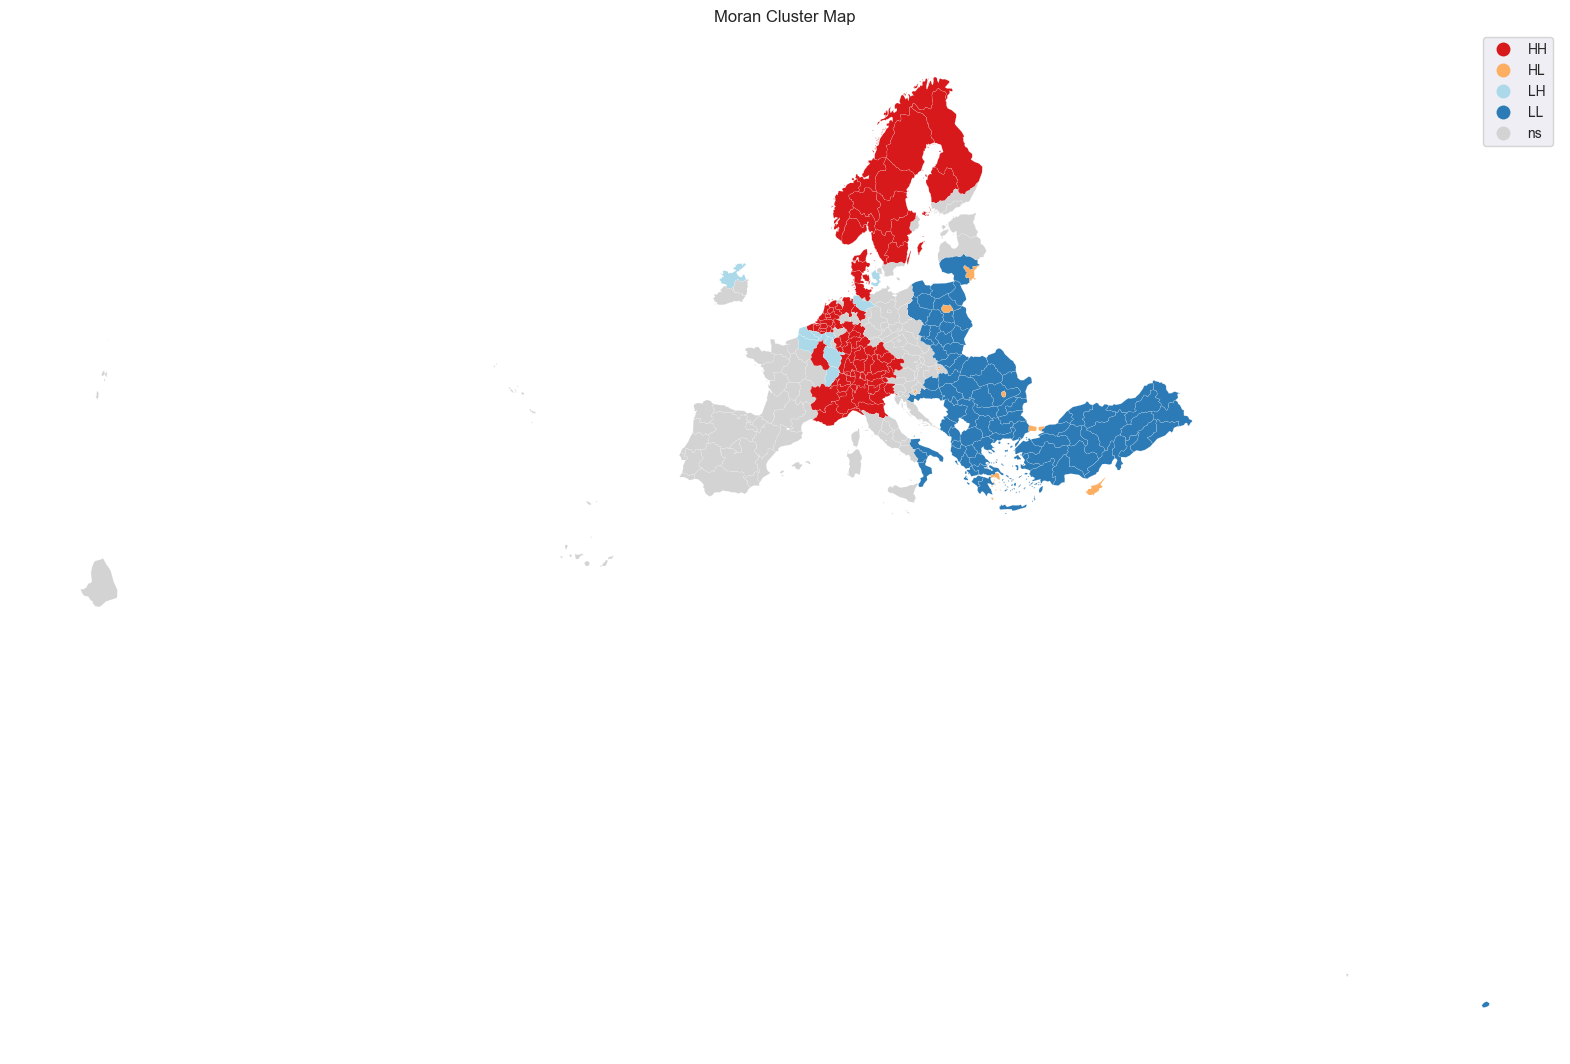

In [84]:
lisa_cluster_map(lisa, gdf_lvl)

# Spatial Outlier Analysis

### Explanatory data loading

In [85]:
exp_data = data_explanatory(False, 'average_all_years')
# explanatory variables
X_df = exp_data[0]
# list of explanatory variables
exp_var_list = exp_data[1]
# list of NUTS regions where explanatory variables have values
exp_regions = list(X_df['NUTS_ID'].unique())

### GDP High-low & Low-high regions

In [86]:
# Reading the HL and LH regions from Results folder
gdf_lvl_analysis = gdf_lvl[gdf_lvl['LISA_sig']=='Significant']
# Selecting only regions for which explanatory variable value exists
gdf_lvl_analysis = gdf_lvl_analysis[gdf_lvl_analysis['NUTS_ID'].isin(exp_regions)]

# Finally, creating two dataframes for significant LH and HL regions
LH_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==2]
HL_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==4]

### Explanatory Data: High-low & Low-high regions

In [87]:
# Merging with gdf_lvl to get the geometries of each location
final_df = pd.merge(X_df, gdf_lvl[['NUTS_ID', 'NAME_LATN', 'NUTS_NAME', 'geometry']], on='NUTS_ID', how='left')

In [88]:
# Calling the user-defined function to do Moran's I analysis on explanatory data
exp_results = explanatory_HL_LH_df_creation(exp_var_list, final_df)

In [89]:
# Extracting all results
global_moran_dict = exp_results[0]
local_moran_percent_dict = exp_results[1]
local_moran_dict = exp_results[2]
LH_region_dict = exp_results[3]
HL_region_dict = exp_results[4]
HH_region_dict = exp_results[5]
LL_region_dict = exp_results[6]

### Bar chart of explanatory variables

In [90]:
# Creating a list of explanatory variable dictionaries and list of spatial cluster types for input into function
exp_dict_list = [LH_region_dict, HL_region_dict, LL_region_dict, HH_region_dict]
spatial_cluster_list = ['Low-High', 'High-Low', 'Low-Low', 'High-High']

#### Low-High regions

In [91]:
gdp_outlier_type = 'Low-High'
create_interactive_bar_graph(LH_regions_GDP, exp_dict_list, spatial_cluster_list, gdp_outlier_type)
# Important to remember that the total number of LH regions is on the higher side at 40 (compared to HL)

#### High-Low regions

In [92]:
gdp_outlier_type = 'High-Low'
create_interactive_bar_graph(HL_regions_GDP, exp_dict_list, spatial_cluster_list, gdp_outlier_type)
# Important to remember that the total number of HL regions is ONLY 12 (much lower compared to LH)

## High- Low Region Graphs

In [93]:
create_categorical_heatmap_HL(HL_regions_GDP, HL_region_dict)

# Spatial Cluster Analysis

### GDP: High-High & Low-Low regions

In [94]:
# Finally, creating two dataframes for significant LH and HL regions
HH_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==1]
LL_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==3]

### Explanatory Data: High-high & Low-low regions

In [95]:
# Extracting results from earlier user-defined function results on GDP outlier and cluster information
HH_region_dict = exp_results[5]
LL_region_dict = exp_results[6]

### Low-Low Regions

In [96]:
# Creating a dataframe with percentage of regions within each country code explained by each explanatory variable
LL_exp_result = country_code_analysis(LL_regions_GDP, LL_region_dict)
exp_df_LL = LL_exp_result[0]
unexplained_countries_LL = LL_exp_result[1]

In [97]:
# Reset the index to get broad categories as a column
exp_df_LL.reset_index(inplace=True)

In [98]:
cluster_type = 'Low-Low'
create_heatmap(exp_df_LL, cluster_type)

### High-High Regions

In [99]:
# Creating a dataframe with percentage of regions within each country code explained by each explanatory variable
HH_exp_result = country_code_analysis(HH_regions_GDP, HH_region_dict)
exp_df_HH = HH_exp_result[0]
unexplained_countries_HH = HH_exp_result[1]

In [100]:
# Reset the index to get broad categories as a column
exp_df_HH.reset_index(inplace=True)

In [101]:
cluster_type = 'High-High'
create_heatmap(exp_df_HH, cluster_type)